# Overview

- EDA
- sample/feature selection
- baseline model
- validation
- submit

【基本の考え方】
- Private LB がテストデータで評価されるため、テストデータに基づいてクリーニング、特徴量選択、訓練データの選択、を行う。
- nb06 のデータセットを変えて公開されたデータセット Toxic Tweets Dataset 版をつくる。

In [1]:
# Directories
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-toxic-severity-rating/sample_submission.csv
/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv
/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv
/kaggle/input/toxic-tweets-dataset/FinalBalancedDataset.csv


In [2]:
# Parameters
DEBUG_FLAG = False
VERSION = 'nb06'

SUBMISSION_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/sample_submission.csv'
VALIDATION_DATA_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv'
COMMENTS_SCORE_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv'
TWEETS_TRAIN_PATH = '/kaggle/input/toxic-tweets-dataset/FinalBalancedDataset.csv'

N_SPLITS = 5 if not DEBUG_FLAG else 2

In [3]:
# Modules
import re
import sys
import time

import datatable as dt
import nltk
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib_venn import venn3
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, SGDClassifier, SGDRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

sys.setrecursionlimit(5000)

In [4]:
# My functions
def read_df():
    valid = dt.fread(VALIDATION_DATA_PATH).to_pandas()
    test = dt.fread(COMMENTS_SCORE_PATH).to_pandas()
    submission = dt.fread(SUBMISSION_PATH).to_pandas()
    tweets = dt.fread(TWEETS_TRAIN_PATH).to_pandas()
    
    if DEBUG_FLAG:
        valid = valid.sample(n=1000).reset_index(drop=True)
        test = test.sample(n=1000).reset_index(drop=True)
        tweets = tweets.sample(n=1000).reset_index(drop=True)
    
    return valid, test, submission, tweets

In [5]:
valid, test, submission, tweets = read_df()

print(f'valid shape: {valid.shape}')
print(f'test shape: {test.shape}')
print(f'submission shape: {submission.shape}')
print(f'tweets shape: {tweets.shape}')

valid shape: (30108, 3)
test shape: (7537, 2)
submission shape: (7537, 2)
tweets shape: (56745, 3)


In [6]:
display(valid.head())
display(test.head())
display(submission.head())
display(tweets.head())

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


,comment_id,score
0,114890,0.5
1,732895,0.5
2,1139051,0.5
3,1434512,0.5
4,2084821,0.5


,C0,Toxicity,tweet
0,0,False,@user when a father is dysfunctional and is so...
1,1,False,@user @user thanks for #lyft credit i can't us...
2,2,False,bihday your majesty
3,3,False,#model i love u take with u all the time in ...
4,4,False,factsguide: society now #motivation


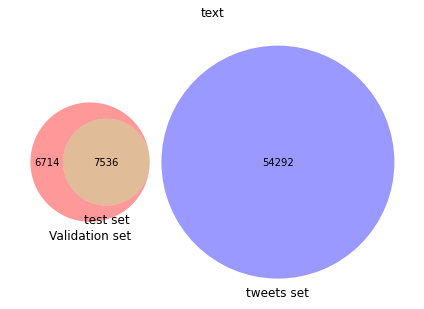

In [7]:
valid_unique_text = set(pd.concat([valid['less_toxic'], valid['more_toxic']]).unique())
test_unique_text = set(test['text'].unique())
tweets_unique_text = set(tweets['tweet'].unique())

plt.figure(figsize=(6,6))
venn3(subsets=(valid_unique_text, test_unique_text, tweets_unique_text),
      set_labels=('Validation set', 'test set', 'tweets set'))
plt.title('text')
plt.tight_layout()
plt.show()

test は validation に含まれている。一方で test は tweets にほとんど含まれていない。アンサンブルに使うスコアをつくるのであれば、ないよりはよいという考え。

方針としては、特徴抽出して、adversarial validation により似ているサンプルセットを使って学習、予測という流れ。

In [8]:
# クリーニング関数
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None, whitelist=None):
    # clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    # remove numbers
    text = re.sub(r'[\d]', '', text)
            
    # Tokenize (convert from string to list)
    lst_text = text.split()
    
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    
    # white words list
    if whitelist is not None:
        lst_text = [word for word in lst_text if word in whitelist]
        
    # back to string from list
    text = ' '.join(lst_text)
    
    return text

In [9]:
%%time
stop_words = list(text.ENGLISH_STOP_WORDS)

# test のクリーニング
test['text_clean'] = test['text'].apply(lambda x: 
    utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words, whitelist=None)
)

test_words = set(' '.join(test['text_clean']).split())
print(f'test_words size: {len(test_words)}')

test_words size: 23636
CPU times: user 13.3 s, sys: 139 ms, total: 13.4 s
Wall time: 13.5 s


In [10]:
%%time

# valid のクリーニング
valid_unique_text = pd.Series(pd.concat([valid['less_toxic'], valid['more_toxic']]).unique())
valid_unique_text_cleaned = valid_unique_text.apply(lambda x: 
    utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words, whitelist=test_words)
)
valid_unique_text_dic = {text: cleaned_text for text, cleaned_text in zip(valid_unique_text, valid_unique_text_cleaned)}
valid['less_toxic_clean'] = valid['less_toxic'].map(valid_unique_text_dic)
valid['more_toxic_clean'] = valid['more_toxic'].map(valid_unique_text_dic)

# wiki のクリーニング
tweets = tweets.rename(columns={'tweet': 'text'})
tweets['text_clean'] = tweets['text'].apply(lambda x: 
    utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words, whitelist=test_words)
)

CPU times: user 41.5 s, sys: 48.3 ms, total: 41.5 s
Wall time: 41.6 s


In [11]:
display(valid[['less_toxic', 'less_toxic_clean']])
display(valid[['more_toxic', 'more_toxic_clean']])
display(test[['text', 'text_clean']])
display(tweets[['text', 'text_clean']])

,less_toxic,less_toxic_clean
0,This article sucks \n\nwoo woo wooooooo,articl suck woo woo wooooooo
1,"""And yes, people should recognize that but the...",ye peopl recogn usual dont object hear direct ...
2,"Western Media?\n\nYup, because every crime in...",western medium yup crime entir world caus west...
3,And you removed it! You numbskull! I don't car...,remov numbskul dont care say anymor life ahead...
4,smelly vagina \n\nBluerasberry why don't you ...,smelli vagina bluerasberri dont model cheesi b...
...,...,...
30103,I'm sorry. I'm not an admin. I will give you t...,im sorri im admin piec advic edit page away gu...
30104,I'm sorry. I'm not an admin. I will give you t...,im sorri im admin piec advic edit page away gu...
30105,"wow...\nare you out of your mind, how was my e...",wow mind edit talk page vandal simpli explain ...
30106,"wow...\nare you out of your mind, how was my e...",wow mind edit talk page vandal simpli explain ...


,more_toxic,more_toxic_clean
0,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,wher sexi pic gone main page
1,Daphne Guinness \n\nTop of the mornin' my fav...,daphn guin mornin favourit alien life form im ...
2,"""Atom you don't believe actual photos of mastu...",atom dont believ actual photo masturb sexual e...
3,You seem to have sand in your vagina.\n\nMight...,sand vagina want wash stink hole bitch
4,"hey \n\nway to support nazis, you racist",hey way support nazi racist
...,...,...
30103,get out my large penis,larg peni
30104,get out my large penis,larg peni
30105,Piss off you slant eyed-gook,piss slant eyedgook
30106,Piss off you slant eyed-gook,piss slant eyedgook


,text,text_clean
0,"""\n \n\nGjalexei, you asked about whether ther...",gjalexei ask antieditori polici call wikipedia...
1,"Looks like be have an abuser , can you please ...",look like abus look thank
2,I confess to having complete (and apparently b...,confess have complet appar bliss ignor jordan ...
3,"""\n\nFreud's ideas are certainly much discusse...",freud idea certainli discus today agre grappl ...
4,It is not just you. This is a laundry list of ...,just laundri list stupid alleg scoop godknowsw...
...,...,...
7532,"Go away, you annoying vandal.",away annoy vandal
7533,This user is a vandal.,user vandal
7534,""" \n\nSorry to sound like a pain, but one by f...",sorri sound like pain follow tad stalk honesti...
7535,Well it's pretty fucking irrelevant now I'm un...,pretti fuck irrelev im unblock aint


,text,text_clean
0,@user when a father is dysfunctional and is so...,user father dysfunct selfish drag kid dysfunct...
1,@user @user thanks for #lyft credit i can't us...,user user thank credit use caus dont offer van...
2,bihday your majesty,majesti
3,#model i love u take with u all the time in ...,model love u u time
4,factsguide: society now #motivation,societi motiv
...,...,...
56740,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,you lie right trash bibl scriptur
56741,"you've gone and broke the wrong heart baby, an...",youv gone broke wrong heart babi drove redneck...
56742,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat like aint fuckin di
56743,youu got wild bitches tellin you lies,got wild bitch tellin lie


In [12]:
# クリーニングにより空文字列になった文字列を抽出
print(sum(test['text_clean'].apply(lambda x: len(x)) == 0), '/', len(test))
print(sum(valid['less_toxic_clean'].apply(lambda x: len(x)) == 0), '/', len(valid))
print(sum(valid['more_toxic_clean'].apply(lambda x: len(x)) == 0), '/', len(valid))
print(sum(tweets['text_clean'].apply(lambda x: len(x)) == 0), '/', len(tweets))

1 / 7537
21 / 30108
21 / 30108
263 / 56745


In [13]:
# 空文字列の行を除く
tweets['word_size'] = tweets['text_clean'].apply(lambda x: len(x))
valid['less_toxic_size'] = valid['less_toxic_clean'].apply(lambda x: len(x))
valid['more_toxic_size'] = valid['more_toxic_clean'].apply(lambda x: len(x))

tweets = tweets.query('word_size != 0')
valid = valid.query('less_toxic_size != 0 | more_toxic_size != 0')

In [14]:
# preparing adversarial validation
advval_train_X = pd.concat([tweets['text_clean'], test['text_clean']])
advval_train_y = pd.concat([pd.Series(np.ones(tweets.shape[0])), pd.Series(np.zeros(test.shape[0]))])
advval_valid_less_X = valid['less_toxic_clean']
advval_valid_more_X = valid['more_toxic_clean']

print(f'advval_train_X shape: {advval_train_X.shape}')
print(f'advval_train_y shape: {advval_train_y.shape}')

advval_train_X shape: (64019,)
advval_train_y shape: (64019,)


In [15]:
%%time

# 特徴抽出
print(f'feature extracting ...')
advval_tfidf = TfidfVectorizer(
    stop_words=stop_words,
    min_df=3,
    max_df=0.5, 
    max_features=100_000,
    analyzer='word',
    ngram_range=(1, 1)
)
advval_train_X_tfidf = advval_tfidf.fit_transform(advval_train_X)
advval_train_X_tfidf_feature_names = advval_tfidf.get_feature_names()
advval_train_X_tfidf_vocab = advval_tfidf.vocabulary_
advval_valid_less_X_tfidf = advval_tfidf.transform(advval_valid_less_X)
advval_valid_more_X_tfidf = advval_tfidf.transform(advval_valid_more_X)

print('Total number of features:', advval_train_X_tfidf.shape[1])

feature extracting ...
Total number of features: 9247
CPU times: user 4.09 s, sys: 23 ms, total: 4.11 s
Wall time: 4.12 s


In [16]:
# idf ranking
idf = {'word': advval_tfidf.get_feature_names(), 'weight': advval_tfidf.idf_}
pd.DataFrame(idf).sort_values('weight', ascending=False)

,word,weight
791,bhadani,10.680656
1023,brixton,10.680656
3242,gale,10.680656
3237,gail,10.680656
3234,gaddafi,10.680656
...,...,...
3775,hoe,3.772401
4689,like,3.549558
6944,rt,3.192503
836,bitch,2.773465


In [17]:
# adversarial validation
def adversarial_validation(train_X, train_y, tfidf):

    models = []
    oof_train = np.zeros((train_X.shape[0],))
    scores = []

    stkf = StratifiedKFold(
        n_splits=N_SPLITS, 
        shuffle=True,
        random_state=None
    )

    # 交差検証
    for fold_id, (train_idx, valid_idx) in enumerate(stkf.split(train_X, train_y)):
        start = time.time()
        print(f'* ' * 40)
        print(f'fold_id: {fold_id}')

        # 訓練データ、評価データ、テストデータを整形
        print(f'preprocessing ...')
        X_trn = train_X.iloc[train_idx].reset_index(drop=True)
        X_val = train_X.iloc[valid_idx].reset_index(drop=True)
        y_trn = train_y.iloc[train_idx].reset_index(drop=True)
        y_val = train_y.iloc[valid_idx].reset_index(drop=True)

        X_trn_tfidf = tfidf.transform(X_trn)
        X_val_tfidf = tfidf.transform(X_val)

        print('Total number of train samples:', X_trn_tfidf.shape[0])
        print('Total number of valid samples:', X_val_tfidf.shape[0])

        # 訓練
        print(f'training ...')
        clf = SGDClassifier(
            loss='log', 
            class_weight='balanced',
            max_iter=10000, 
            tol=1e-3, 
            n_jobs=-1
        )

        clf.fit(X_trn_tfidf, y_trn)

        # 推論
        print(f'predicting ...')
        val_pred = clf.predict_proba(X_val_tfidf)[:, 1]
        oof_train[valid_idx] = val_pred
        models.append(clf)

        # 評価
        print(f'validation ...')
        score_auc = roc_auc_score(y_val, val_pred)
        scores.append(score_auc)
        elapsed = time.time() - start
        print(f'fold {fold_id} - score: {score_auc:.6f}, elapsed time: {elapsed:.2f} [sec]')

    print(f'* ' * 40)
    print(f'Average AUC: {sum(scores)/N_SPLITS:.6f}')
    
    return oof_train, models

In [18]:
%%time
advval_oof_train, advval_models = adversarial_validation(advval_train_X, advval_train_y, advval_tfidf)

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 0
preprocessing ...
Total number of train samples: 51215
Total number of valid samples: 12804
training ...
predicting ...
validation ...
fold 0 - score: 0.979626, elapsed time: 1.36 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 1
preprocessing ...
Total number of train samples: 51215
Total number of valid samples: 12804
training ...
predicting ...
validation ...
fold 1 - score: 0.976522, elapsed time: 1.33 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 2
preprocessing ...
Total number of train samples: 51215
Total number of valid samples: 12804
training ...
predicting ...
validation ...
fold 2 - score: 0.976253, elapsed time: 1.39 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 3
preprocessing ...
Total number of train samples: 51215
Total number of val

Average AUC が 0.80 程度だと train と test を分離できそうな分類器ができたということ。すなわち、訓練データとテストデータの特徴量分布が異なることを意味している。いま、訓練データをラベル1、テストデータをラベル0としたので、スコアの低い訓練データを取り出すことで、テストデータに近い訓練データが手に入る。

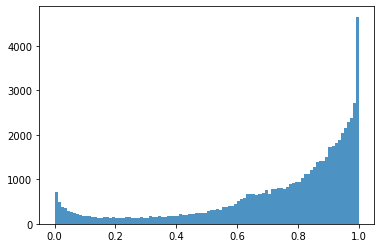

In [19]:
# スコア分布
plt.figure()
plt.hist(advval_oof_train, alpha=.8, bins=100)
plt.show()

In [20]:
advval_oof_train = pd.DataFrame({'oof_train': advval_oof_train, 'y': advval_train_y})
advval_oof_train

,oof_train,y
0,0.816850,1.0
1,0.920340,1.0
2,0.659851,1.0
3,0.946754,1.0
4,0.755582,1.0
...,...,...
7532,0.092527,0.0
7533,0.595873,0.0
7534,0.012766,0.0
7535,0.315220,0.0


In [21]:
# 訓練データのうちテストデータに近いサンプルを抽出
advval_oof_train.query('oof_train < 0.5 & y == 1')

,oof_train,y
5,0.439840,1.0
14,0.355676,1.0
17,0.345470,1.0
101,0.455073,1.0
106,0.231621,1.0
...,...,...
56379,0.407320,1.0
56401,0.495345,1.0
56440,0.380521,1.0
56470,0.312002,1.0


In [22]:
advval_train_idx = advval_oof_train.query('oof_train < 0.5 & y == 1').index
print(len(advval_train_idx))

3240


In [23]:
tweets

,C0,Toxicity,text,text_clean,word_size
0,0,False,@user when a father is dysfunctional and is so...,user father dysfunct selfish drag kid dysfunct...,50
1,1,False,@user @user thanks for #lyft credit i can't us...,user user thank credit use caus dont offer van...,56
2,2,False,bihday your majesty,majesti,7
3,3,False,#model i love u take with u all the time in ...,model love u u time,19
4,4,False,factsguide: society now #motivation,societi motiv,13
...,...,...,...,...,...
56740,56740,True,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,you lie right trash bibl scriptur,33
56741,56741,True,"you've gone and broke the wrong heart baby, an...",youv gone broke wrong heart babi drove redneck...,52
56742,56742,True,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat like aint fuckin di,44
56743,56743,True,youu got wild bitches tellin you lies,got wild bitch tellin lie,25


In [24]:
# preparing main training data
main_train_X = tweets.iloc[advval_train_idx]['text_clean']
main_train_y = tweets.iloc[advval_train_idx]['Toxicity'].astype(int)
main_valid_less_X = valid['less_toxic_clean']
main_valid_more_X = valid['more_toxic_clean']

print(f'main_train_X shape: {advval_train_X.shape}')
print(f'main_train_y shape: {advval_train_y.shape}')
print(f'main_valid_less_X shape: {main_valid_less_X.shape}')
print(f'main_valid_more_X shape: {main_valid_more_X.shape}')

main_train_X shape: (64019,)
main_train_y shape: (64019,)
main_valid_less_X shape: (30108,)
main_valid_more_X shape: (30108,)


In [25]:
# 特徴抽出
print(f'feature extracting ...')
main_tfidf = TfidfVectorizer(
    stop_words=stop_words,
    min_df=3,
    max_df=0.5, 
    max_features=100_000,
    analyzer='word',
    ngram_range=(1, 1)
)

main_train_X_tfidf = main_tfidf.fit_transform(main_train_X)
main_train_X_tfidf_feature_names = main_tfidf.get_feature_names()
main_train_X_tfidf_vocab = main_tfidf.vocabulary_
main_valid_less_X_tfidf = main_tfidf.transform(main_valid_less_X)
main_valid_more_X_tfidf = main_tfidf.transform(main_valid_more_X)

print('Total number of features:', main_train_X_tfidf.shape[1])

feature extracting ...
Total number of features: 1319


In [26]:
# idf ranking
idf = {'word': main_tfidf.get_feature_names(), 'weight': main_tfidf.idf_}
pd.DataFrame(idf).sort_values('weight', ascending=False)

,word,weight
1318,zionism,7.697343
439,finger,7.697343
541,heritag,7.697343
536,heck,7.697343
1170,tip,7.697343
...,...,...
676,like,3.534561
844,peopl,3.500141
624,just,3.420677
354,dont,3.373210


In [27]:
# main
def main_training(train_X, train_y, tfidf):

    models = []
    oof_train = np.zeros((train_X.shape[0],))
    scores = []

    kf = KFold(
        n_splits=N_SPLITS, 
        shuffle=True,
        random_state=None
    )

    # 交差検証
    for fold_id, (train_idx, valid_idx) in enumerate(kf.split(train_X, train_y)):
        start = time.time()
        print(f'* ' * 40)
        print(f'fold_id: {fold_id}')

        # 訓練データ、評価データ、テストデータを整形
        print(f'preprocessing ...')
        X_trn = train_X.iloc[train_idx].reset_index(drop=True)
        X_val = train_X.iloc[valid_idx].reset_index(drop=True)
        y_trn = train_y.iloc[train_idx].reset_index(drop=True)
        y_val = train_y.iloc[valid_idx].reset_index(drop=True)

        X_trn_tfidf = tfidf.transform(X_trn)
        X_val_tfidf = tfidf.transform(X_val)

        print('Total number of train samples:', X_trn_tfidf.shape[0])
        print('Total number of valid samples:', X_val_tfidf.shape[0])

        # 訓練
        print(f'training ...')
        clf = MultinomialNB()
        clf.fit(X_trn_tfidf, y_trn)

        # 推論
        print(f'predicting ...')
        val_pred = clf.predict_proba(X_val_tfidf)[:, 1]
        oof_train[valid_idx] = val_pred
        models.append(clf)

        # 評価
        print(f'validation ...')
        score_auc = roc_auc_score(y_val, val_pred)
        scores.append(score_auc)
        elapsed = time.time() - start
        print(f'fold {fold_id} - score: {score_auc:.6f}, elapsed time: {elapsed:.2f} [sec]')

    print(f'* ' * 40)
    print(f'Average AUC: {sum(scores)/N_SPLITS:.6f}')
    
    return oof_train, models

In [28]:
%%time
main_oof_train, main_models = main_training(main_train_X, main_train_y, main_tfidf)

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 0
preprocessing ...
Total number of train samples: 2592
Total number of valid samples: 648
training ...
predicting ...
validation ...
fold 0 - score: 0.890067, elapsed time: 0.06 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 1
preprocessing ...
Total number of train samples: 2592
Total number of valid samples: 648
training ...
predicting ...
validation ...
fold 1 - score: 0.875528, elapsed time: 0.07 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 2
preprocessing ...
Total number of train samples: 2592
Total number of valid samples: 648
training ...
predicting ...
validation ...
fold 2 - score: 0.892716, elapsed time: 0.07 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 3
preprocessing ...
Total number of train samples: 2592
Total number of valid samples

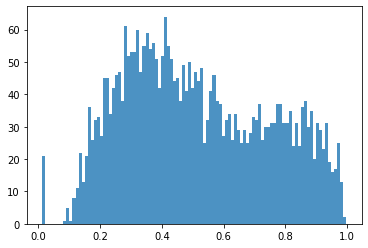

In [29]:
# スコア分布
plt.figure()
plt.hist(main_oof_train, alpha=.8, bins=100)
plt.show()

In [30]:
# adversarial validation によりテストデータに近い評価データを作成
advval_score_valid_less_toxic = np.array([clf.predict_proba(advval_valid_less_X_tfidf)[:, 1] for clf in advval_models]).sum(axis=0) / N_SPLITS
advval_score_valid_more_toxic = np.array([clf.predict_proba(advval_valid_more_X_tfidf)[:, 1] for clf in advval_models]).sum(axis=0) / N_SPLITS

test_like_valid_idx = (advval_score_valid_less_toxic < 0.5) & (advval_score_valid_more_toxic < 0.5)
print(sum(test_like_valid_idx), '/', len(test_like_valid_idx))

25336 / 30108


In [31]:
# validation score
preds_less_toxic = np.array([clf.predict_proba(main_valid_less_X_tfidf[test_like_valid_idx])[:, 1] for clf in main_models]).sum(axis=0)
preds_more_toxic = np.array([clf.predict_proba(main_valid_more_X_tfidf[test_like_valid_idx])[:, 1] for clf in main_models]).sum(axis=0)

print(f'{(preds_less_toxic < preds_more_toxic).mean():.6f}')

0.599582


In [32]:
test_X_tfidf = main_tfidf.transform(test['text_clean'])
preds_test = np.array([clf.predict_proba(test_X_tfidf)[:, 1] for clf in main_models]).sum(axis=0) / N_SPLITS
submission['score'] = preds_test

pd.DataFrame(pd.Series(submission['score'].ravel()).describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
0,7537.0,0.424467,0.204088,0.034828,0.26783,0.394884,0.552355,0.993947


In [33]:
submission.to_csv('submission.csv', index=False)
submission

,comment_id,score
0,114890,0.255212
1,732895,0.696966
2,1139051,0.393945
3,1434512,0.370333
4,2084821,0.340907
...,...,...
7532,504235362,0.541969
7533,504235566,0.550327
7534,504308177,0.268665
7535,504570375,0.656908
